Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Longitud de Worker 0: 5
Longitud de Worker 1: 11
Longitud de Worker 2: 4
Longitud de Worker 3: 14
Longitud de Worker 4: 10
Longitud de Worker 5: 10
Longitud de Worker 6: 12
Longitud de Worker 7: 11
Longitud de Worker 8: 16
Longitud de Worker 9: 11
Longitud de Worker 10: 14
Longitud de Worker 11: 13


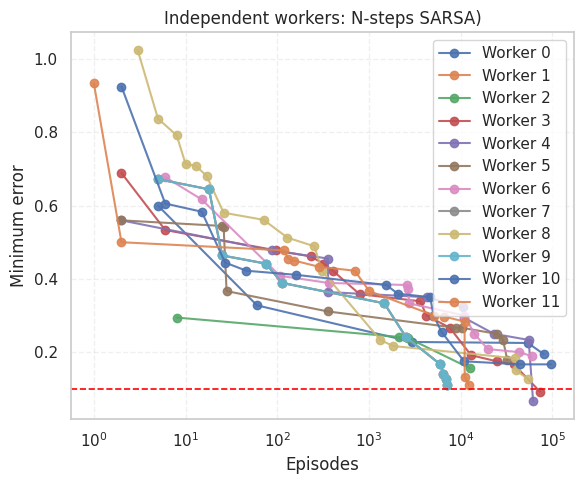

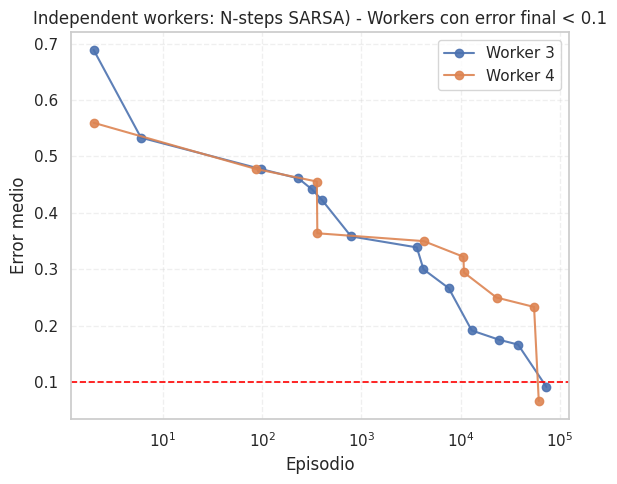

Longitud de Worker 0: 16
Longitud de Worker 1: 16
Longitud de Worker 2: 16
Longitud de Worker 3: 16
Longitud de Worker 4: 16
Longitud de Worker 5: 16
Longitud de Worker 6: 16
Longitud de Worker 7: 16
Longitud de Worker 8: 16
Longitud de Worker 9: 16
Longitud de Worker 10: 16
Longitud de Worker 11: 16


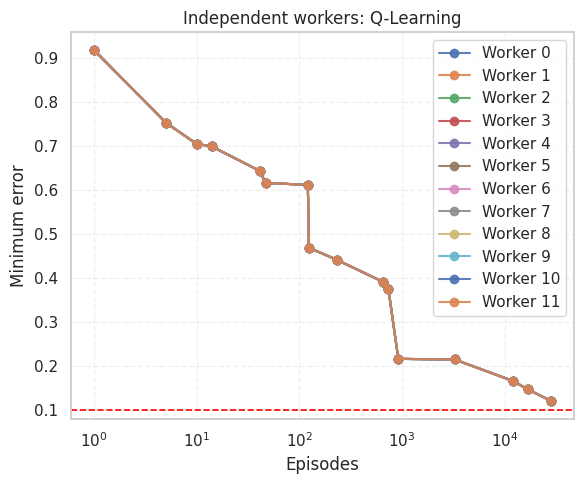

Longitud de Worker 0: 11
Longitud de Worker 1: 11
Longitud de Worker 2: 9
Longitud de Worker 3: 8
Longitud de Worker 4: 13
Longitud de Worker 5: 13
Longitud de Worker 6: 8
Longitud de Worker 7: 11
Longitud de Worker 8: 4
Longitud de Worker 9: 11
Longitud de Worker 10: 10
Longitud de Worker 11: 9


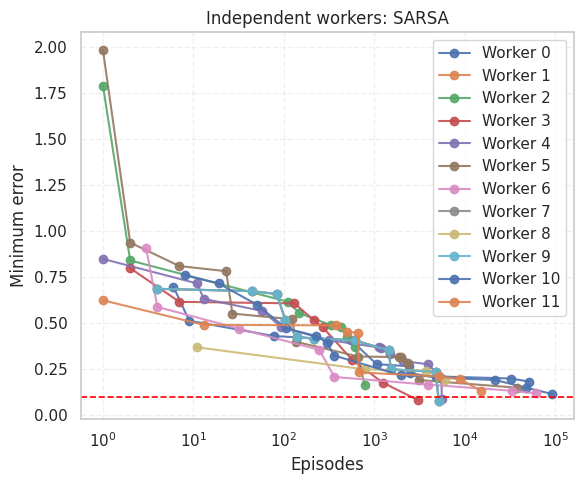

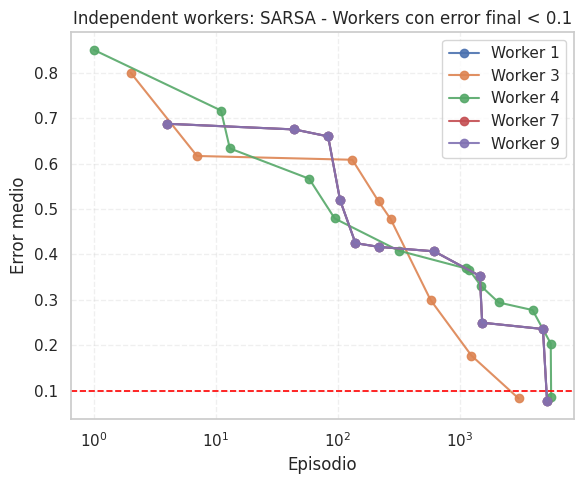

In [4]:
from __future__ import annotations
import re
import math
import pandas as pd
import seaborn as sns
from datetime import datetime
from dataclasses import dataclass
from pathlib import Path
from typing import List, Dict, Iterable, Optional, Union
from glob import glob
import matplotlib.pyplot as plt
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

@dataclass(frozen=True)
class LogEntry:
    """Punto de datos con episodio y error medio."""
    episode: int
    error_mean: float


@dataclass
class WorkerSeries:
    """Serie de episodios y errores para un worker."""
    worker_id: int
    entries: List[LogEntry]

    @property
    def label(self) -> str:
        return f"Worker {self.worker_id}"

    @property
    def episodes(self) -> List[int]:
        return [e.episode for e in self.entries]

    @property
    def errors(self) -> List[float]:
        return [e.error_mean for e in self.entries]


class LogParser:
    """
    Parser de logs con formato tipo:
    'Episode 2978 ... con error medio:0.2277777'
    Detecta worker_id desde el contenido (worker_id X) o desde el nombre del archivo (worker_X).
    - Elimina episodio==0
    - Agrega un punto final con episodio=append_final_episode (por defecto 100000)
      copiando el último error disponible.
    """
    _episode_error_re = re.compile(
        r"Episode\s+(\d+).*?error\s*medio\s*:\s*([+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?)",
        re.IGNORECASE
    )

    _worker_in_content_re = re.compile(
        r"worker[\s_-]*id\s*[:=]?\s*(\d+)",
        re.IGNORECASE
    )

    _worker_in_filename_re = re.compile(
        r"worker[_-](\d+)",
        re.IGNORECASE
    )

    def __init__(self, append_final_episode: Optional[int] = 100000):
        self.append_final_episode = append_final_episode

    def parse_file(self, path: Union[str, Path]) -> Optional[WorkerSeries]:
        path = Path(path)
        text = path.read_text(encoding="utf-8", errors="ignore")

        worker_id = self._extract_worker_id(text, path)

        by_episode: Dict[int, float] = {}
        for line in text.splitlines():
            m = self._episode_error_re.search(line)
            if not m:
                continue
            ep = int(m.group(1))
            err = float(m.group(2))
            by_episode[ep] = err  # conserva el último visto por episodio

        # 1) Eliminar episodio==0
        if 0 in by_episode:
            by_episode.pop(0, None)

        if not by_episode:
            print(f"[AVISO] No se encontraron episodios válidos (distintos de 0) en: {path.name}")
            return None

        entries = [LogEntry(ep, by_episode[ep]) for ep in sorted(by_episode.keys())]
        return WorkerSeries(worker_id=worker_id, entries=entries)

    def _extract_worker_id(self, text: str, path: Path) -> int:
        m = self._worker_in_content_re.search(text)
        if m:
            return int(m.group(1))
        m2 = self._worker_in_filename_re.search(path.name)
        if m2:
            return int(m2.group(1))
        return -1  # desconocido


class LogCollection:
    """Carga y agrega múltiples WorkerSeries desde rutas de archivo."""
    def __init__(self, parser: Optional[LogParser] = None):
        self.parser = parser or LogParser()

    def load(self, paths: Iterable[Union[str, Path]]) -> List[WorkerSeries]:
        series: List[WorkerSeries] = []
        for p in paths:
            p = Path(p)
            if not p.exists():
                print(f"[AVISO] Archivo no encontrado: {p}")
                continue
            try:
                ws = self.parser.parse_file(p)
                if ws is not None and ws.entries:
                    series.append(ws)
            except Exception as e:
                print(f"[AVISO] Falló el parseo de {p.name}: {e}")
        return series

class Plotter:
    """Genera la gráfica episodio vs error medio para múltiples series,
    y una gráfica extra con workers cuyo error final < threshold.
    """
    def plot(
        self,
        series_list: List[WorkerSeries],
        title: str = "Error medio vs Episodio",
        figsize: tuple = (6, 5),
        save_path: Optional[Union[str, Path]] = None,
        save_path_filtered: Optional[Union[str, Path]] = None,
        show: bool = True,
        alpha: float = 0.9,
        linewidth: float = 1.5,
        marker: Optional[str] = "o",
        logX: bool = False,
        logY: bool = False,
        threshold: float = 0.1,
        make_filtered_plot: bool = True,
    ) -> None:
        if not series_list:
            raise ValueError(
                "No hay series para graficar. Verifica que los archivos existen y contienen 'Episode ... error medio:...'"
            )
        sns.set(style="whitegrid")

        # Helper: último error válido (no-NaN, finito) de una serie
        def last_valid_error(errors) -> Optional[float]:
            for v in reversed(errors):
                if v is None:
                    continue
                if isinstance(v, float) or isinstance(v, int):
                    if math.isfinite(v):
                        return float(v)
            return None

        # Detectar workers con error final < threshold
        workers_filtrados = []
        for s in series_list:
            lv = last_valid_error(s.errors)
            if lv is not None and lv < threshold:
                workers_filtrados.append(s)

        # Función de trazado coherente con flags
        def do_plot(x, y, label):
            if logX and logY:
                plt.loglog(x, y, label=label, alpha=alpha, linewidth=linewidth, marker=marker)
            elif logX:
                plt.semilogx(x, y, label=label, alpha=alpha, linewidth=linewidth, marker=marker)
            elif logY:
                plt.semilogy(x, y, label=label, alpha=alpha, linewidth=linewidth, marker=marker)
            else:
                plt.plot(x, y, label=label, alpha=alpha, linewidth=linewidth, marker=marker)

        # -------- Gráfica principal --------
        plt.figure(figsize=figsize)

        plotted_any = False
        for s in series_list:
            x = s.episodes
            y = s.errors
            print(f"Longitud de {s.label}: " + str(len(x)))

            # Filtrado para escalas log: no se permiten valores <= 0
            if logX or logY:
                filtered_x = []
                filtered_y = []
                for xi, yi in zip(x, y):
                    if logX and xi <= 0:
                        continue
                    if logY and (yi is None or yi <= 0):
                        continue
                    filtered_x.append(xi)
                    filtered_y.append(yi)
                x, y = filtered_x, filtered_y

            if not x or not y:
                print(f"[AVISO] Serie vacía tras filtrar para escala log: {s.label}")
                continue

            do_plot(x, y, s.label)
            plotted_any = True

        if not plotted_any:
            raise ValueError("No se pudo graficar ninguna serie (posibles valores no positivos con escala log).")

        # Línea horizontal de umbral (una sola vez)
        plt.axhline(y=threshold, color='red', linestyle='--', linewidth=1.2)

        plt.title(title)
        plt.xlabel("Episodes")
        plt.ylabel("Minimum error")
        plt.grid(True, linestyle="--", alpha=0.3)
        plt.legend(loc="best")
        plt.tight_layout()

        if save_path is not None:
            plt.savefig(str(save_path), dpi=200)

        # -------- Gráfica filtrada (solo si hay elegibles) --------
        if make_filtered_plot and workers_filtrados:
            plt.figure(figsize=figsize)

            plotted_any_filtered = False
            for s in workers_filtrados:
                x = s.episodes
                y = s.errors

                if logX or logY:
                    filtered_x = []
                    filtered_y = []
                    for xi, yi in zip(x, y):
                        if logX and xi <= 0:
                            continue
                        if logY and (yi is None or yi <= 0):
                            continue
                        filtered_x.append(xi)
                        filtered_y.append(yi)
                    x, y = filtered_x, filtered_y

                if not x or not y:
                    # Si en log no quedan puntos, se omite
                    continue

                do_plot(x, y, s.label)
                plotted_any_filtered = True

            if plotted_any_filtered:
                plt.axhline(y=threshold, color='red', linestyle='--', linewidth=1.2)
                plt.title(f"{title} - Workers con error final < {threshold}")
                plt.xlabel("Episodio")
                plt.ylabel("Error medio")
                plt.grid(True, linestyle="--", alpha=0.3)
                plt.legend(loc="best")
                plt.tight_layout()

                if save_path_filtered is not None:
                    plt.savefig("Filtrado_"+str(save_path_filtered), dpi=200)
            else:
                # Ninguno quedó ploteable bajo las restricciones log
                pass

        if show:
            plt.show()
        else:
            plt.close()


class FileLocator:
    """Localiza archivos de log dada una carpeta, patrón o lista de rutas."""
    def __init__(self, patterns: Optional[List[str]] = None, recursive: bool = True):
        self.patterns = patterns or ["*.txt", "*.log"]
        self.recursive = recursive

    def resolve(self, target: Union[str, Path, Iterable[Union[str, Path]]]) -> List[Path]:
        # 1) Iterable explícito de rutas
        if isinstance(target, (list, tuple, set)):
            return [Path(p) for p in target]

        # 2) Cadena o Path único
        target = Path(target) if not isinstance(target, Path) else target

        # 2.a) Es carpeta: buscar con patrones
        if target.exists() and target.is_dir():
            files: List[Path] = []
            for pat in self.patterns:
                it = target.rglob(pat) if self.recursive else target.glob(pat)
                files.extend(it)
            files = sorted(set(files))  # quitar duplicados y ordenar
            return files

        # 2.b) Patrón glob como "ruta/**/*.txt"
        pattern_str = str(target)
        files = [Path(p) for p in glob(pattern_str, recursive=True)]
        return sorted(files)


class LogPlotApp:
    """Fachada para localizar logs, cargarlos y graficar en una sola llamada."""
    def __init__(
        self,
        parser: Optional[LogParser] = None,
        plotter: Optional[Plotter] = None,
        patterns: Optional[List[str]] = None,
        recursive: bool = True
    ):
        self.collection = LogCollection(parser or LogParser())
        self.plotter = plotter or Plotter()
        self.locator = FileLocator(patterns=patterns, recursive=recursive)

    def run(
        self,
        target: Union[str, Path, Iterable[Union[str, Path]]],
        title: str = "Error medio vs Episodio",
        save_path: Optional[Union[str, Path]] = None,
        show: bool = True,
        logX: bool = False,
        logY: bool = False,
    ) -> List[WorkerSeries]:
        files = self.locator.resolve(target)
        if not files:
            where = target if isinstance(target, (str, Path)) else "<lista vacía>"
            pats = ", ".join(self.locator.patterns)
            raise FileNotFoundError(
                f"No se encontraron archivos en '{where}' con patrones [{pats}] (recursive={self.locator.recursive})."
            )

        series_list = self.collection.load(files)
        series_list = [s for s in series_list if s.entries]

        if not series_list:
            raise ValueError("Se encontraron archivos pero ningún episodio fue parseado. Revisa el formato de 'Episode ... error medio:'")

        # Ordenar por worker_id para consistencia
        series_list.sort(key=lambda s: s.worker_id)

        self.plotter.plot(
            series_list,
            title=title,
            save_path=save_path,
            show=show,
            logX=logX,
            logY=logY,
        )
        return series_list


if __name__ == "__main__":
    app = LogPlotApp(patterns=["*.txt", "*.log"], recursive=True)
    app.run("/content/drive/MyDrive/Reinforcement Learning Multiplicadores/Análisis de datos/Logs Iniciales/Workers Independientes/SARSA n-steps",
            title="Independent workers: N-steps SARSA)", save_path="errores_workers_SARSA_nsteps.pdf", show=True, logX=True, logY=False)
    app.run("/content/drive/MyDrive/Reinforcement Learning Multiplicadores/Análisis de datos/Logs Iniciales/Workers Independientes/Q-Learning",
            title="Independent workers: Q-Learning", save_path="errores_workers_Q-Learning.pdf", show=True, logX=True, logY=False)
    app.run("/content/drive/MyDrive/Reinforcement Learning Multiplicadores/Análisis de datos/Logs Iniciales/Workers Independientes/SARSA",
            title="Independent workers: SARSA", save_path="errores_workers_SARSA.pdf", show=True, logX=True, logY=False)